In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import prophet
import itertools

from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

import warnings
warnings.filterwarnings("ignore")

### Forecasting data harian
#### Model SARIMA

In [3]:
data = pd.read_excel(
    "../data/Daily Update Data Agregat Covid-19 Jakarta.xlsx", sheet_name="Data Jakarta")
positif_harian = data[["Tanggal", "Positif Harian"]]
positif_harian["Tanggal"] = pd.to_datetime(positif_harian["Tanggal"])
positif_harian.set_index("Tanggal", inplace=True)
positif_harian.head()

,Positif Harian
Tanggal,
2020-03-01,0
2020-03-02,0
2020-03-03,3
2020-03-04,0
2020-03-05,4


In [4]:
def adfuller_test(df):
    result = adfuller(df)
    print("ADF Statistic: %f" % result[0])
    print("p-value: %f" % result[1])
    if result[1] < 0.05:
        print("stationary")
    else:
        print("not stationary")

adfuller_test(positif_harian["Positif Harian"])

ADF Statistic: -4.227311
p-value: 0.000592
stationary


Dari hasil ADF test dengan rentang kepercayaan 95%, didapati bahwa data positif harian termasuk stationary. Berarti, differencing tidak diperlukan

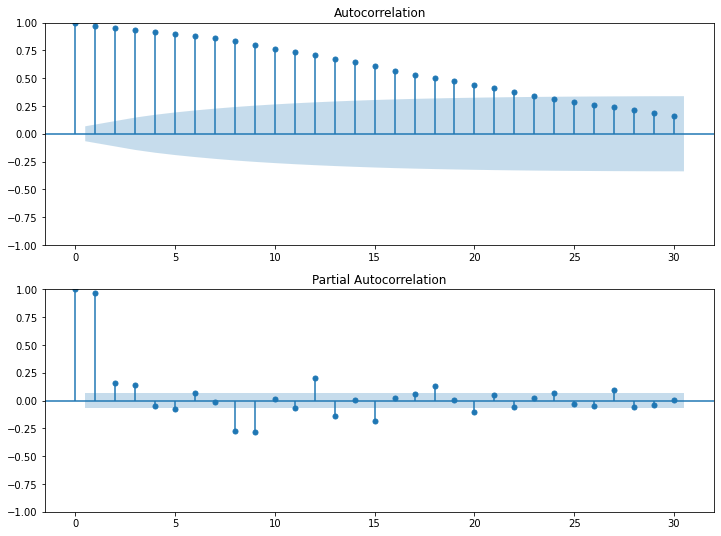

In [5]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
plot_acf(positif_harian["Positif Harian"], ax=ax1)
plot_pacf(positif_harian["Positif Harian"], ax=ax2)
fig.set_size_inches(12, 9)

Karena plot autocorrelation memiliki pola exponential dan plot partial autocorrelation mengalami drop secara signifikan setelah 2 lag, maka p order (AR) tidak diperlukan, sementara q ordernya (MA) adalah 2.

<AxesSubplot:xlabel='Tanggal'>

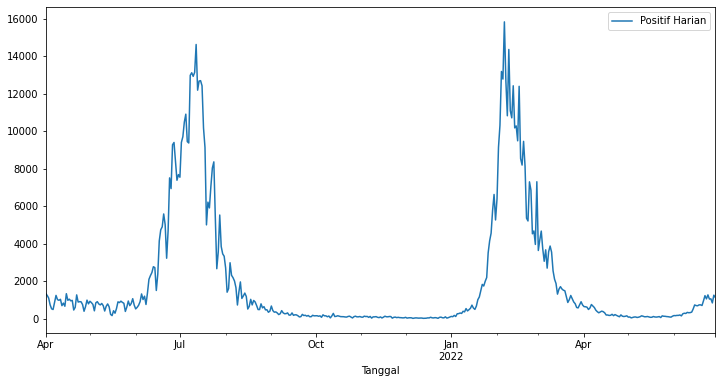

In [6]:
positif_harian_trim = positif_harian.loc["2021-04":]
positif_harian_trim.plot(figsize=(12, 6))

Dari plot diatas, didapati bahwa kenaikan dan penurunan kasus positif covid setiap $\pm$ 8 bulan sekali. Maka, s = 8 * 30 

In [ ]:
model = sm.tsa.statespace.SARIMAX(
    positif_harian_trim["Positif Harian"], order=(0, 0, 2), seasonal_order=(0, 0, 2, 240))
results=model.fit()

<AxesSubplot:xlabel='Tanggal'>

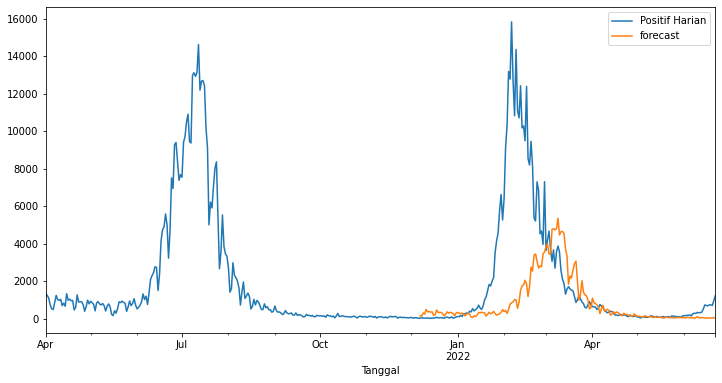

In [ ]:
positif_harian_trim["forecast"] = results.predict(
    start=250, dynamic=True)
positif_harian_trim.plot(figsize=(12, 6))

In [ ]:
future_date = [positif_harian_trim.index[-1] + DateOffset(days=x) for x in range(0, 120)] # 4 bulan
future_date_df = pd.DataFrame(index=future_date[1:],columns=positif_harian_trim.columns)
future_date_df_merge = pd.concat([positif_harian_trim, future_date_df])

<AxesSubplot:>

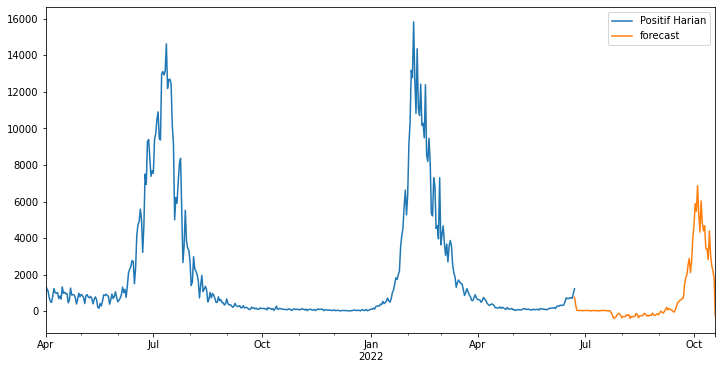

In [ ]:
future_date_df_merge["forecast"] = results.predict(
    start=447, end=807, dynamic=True)
future_date_df_merge.plot(figsize=(12, 6))

Dari hasil forecasting, maka diperkirakan bahwa pada bulan oktober akan terjadi kenaikan lonjakan kasus terkonfirmasi positif covid-19.

##### Evaluation

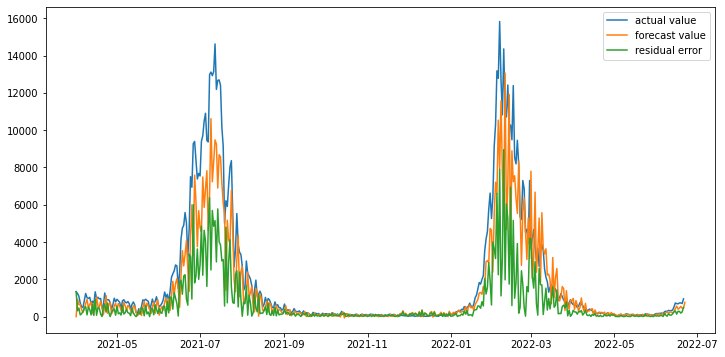

{'mae': 722.021821212612, 'rmse': 1527.6322395926181}

In [ ]:
def forecast_accuracy(forecast, actual):
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mae': mae, 
            'rmse':rmse})

actual_value = positif_harian_trim["Positif Harian"][:447]
forecast_value = results.predict(start=0, end=447, dynamic=False)

plt.figure(figsize=(12, 6))
plt.plot(actual_value, label="actual value")
plt.plot(forecast_value, label="forecast value")
plt.plot(abs(forecast_value - actual_value), label="residual error")
plt.legend()
plt.show()

forecast_accuracy(forecast_value, actual_value)

#### Model Prophet

In [ ]:
positif_harian_cp = positif_harian.copy()
positif_harian_cp.columns = ["ds", "y"]
model = prophet.Prophet()
model.fit(positif_harian_cp)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

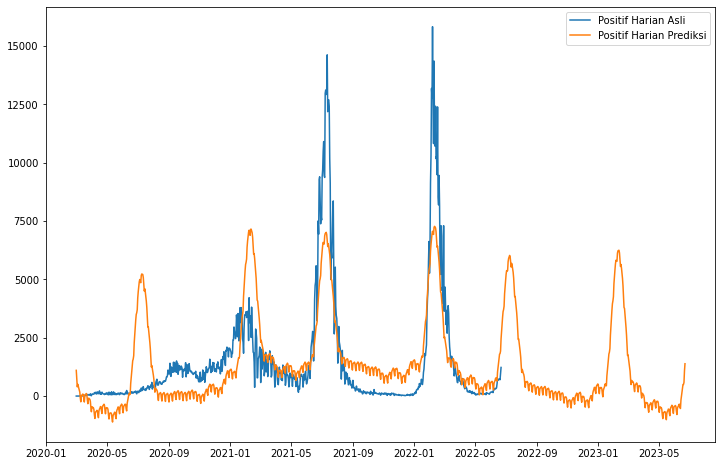

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(positif_harian["Tanggal"], positif_harian["Positif Harian"], label="Positif Harian Asli")
plt.plot(forecast["ds"], forecast["yhat"], label="Positif Harian Prediksi")
plt.legend()
plt.show()

In [ ]:
# Hyperparameter Tuning

positif_harian_new = positif_harian.copy()
positif_harian_new.columns = ["ds", "y"]
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

all_params = [dict(zip(param_grid.keys(), v))
              for v in itertools.product(*param_grid.values())]
rmses = []  


for params in all_params:
    m = prophet.Prophet(**params).fit(positif_harian_new)
    df_cv = cross_validation(
        m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO

    changepoint_prior_scale  seasonality_prior_scale         rmse
0                     0.001                     0.01  3303.993764
1                     0.001                     0.10  3232.194988
2                     0.001                     1.00  3225.483670
3                     0.001                    10.00  3236.322201
4                     0.010                     0.01  3510.058930
5                     0.010                     0.10  3428.205509
6                     0.010                     1.00  3416.896204
7                     0.010                    10.00  3428.672652
8                     0.100                     0.01  4268.208625
9                     0.100                     0.10  4456.938813
10                    0.100                     1.00  4517.193446
11                    0.100                    10.00  4504.466765
12                    0.500                     0.01  3824.252138
13                    0.500                     0.10  4360.942913
14        

RMSE terbaik sekitar 3225.483670

**Catatan**\
Dari kedua model, didapati bahwa ternyata covid masih memiliki tren naik.